---
클래스 지정 하지 않은 테스트, 원리 파악용<br>
Playground

In [12]:
import xml.etree.ElementTree as ET
import torch

def class_to_idx(label, class_mapping):
    return class_mapping[label]

def IdxToLabel(labels):
    for label in labels:
        if label is not None:
            print(idx_mapping[int(label.item())])
        else:
            print("label has no value!")
            
# Example class mapping dictionary
class_mapping = {
    'red apple': 1,
    'green apple': 2,
}

idx_mapping = {
    1 : 'red apple',
    2 : 'green apple',
}

# Parse the XML file
tree = ET.parse('annotations/apple10_jpg.rf.3c9df9e888768e471d4d2dd2cfcbce46.xml')
root = tree.getroot()

# Initialize lists to hold box coordinates and labels
boxes = []
labels = []

# Iterate over all objects in the XML
for obj in root.iter('object'):
    name = obj.find('name').text
    xmlbox = obj.find('bndbox')
    xmin = int(xmlbox.find('xmin').text)
    ymin = int(xmlbox.find('ymin').text)
    xmax = int(xmlbox.find('xmax').text)
    ymax = int(xmlbox.find('ymax').text)
    boxes.append([xmin, ymin, xmax, ymax])
    labels.append(name)

# Convert boxes and labels to tensors
boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.as_tensor([class_to_idx(label, class_mapping) for label in labels], dtype=torch.int64)



print(boxes)
print(labels)
IdxToLabel(labels)


tensor([[274., 187., 363., 268.],
        [496., 162., 606., 267.],
        [151., 176., 252., 270.]])
tensor([1, 1, 2])
red apple
red apple
green apple


In [13]:
# cuda 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


---
데이터로더 확인하기

In [14]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
from PIL import Image

# 클래스 이름을 인덱스로 매핑하는 함수
def class_to_idx(label, class_mapping):
    return class_mapping[label]

# Example class mapping dictionary
class_mapping = {
    'red apple': 1,
    'green apple': 2,
}

# Dataset 지정
class CustomDataset(Dataset):
    def __init__(self, img_dir, anno_dir, class_mapping, transforms=None):
        self.img_dir = img_dir
        self.anno_dir = anno_dir
        self.class_mapping = class_mapping
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(img_dir)))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        anno_path = os.path.join(self.anno_dir, self.imgs[idx].replace('.jpg', '.xml'))
        
        img = Image.open(img_path).convert("RGB")
        
        # XML 파일에서 annotation 정보 추출
        tree = ET.parse(anno_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.iter('object'):
            name = obj.find('name').text
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            ymin = int(xmlbox.find('ymin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymax = int(xmlbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(name)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([class_to_idx(l, self.class_mapping) for l in labels], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target



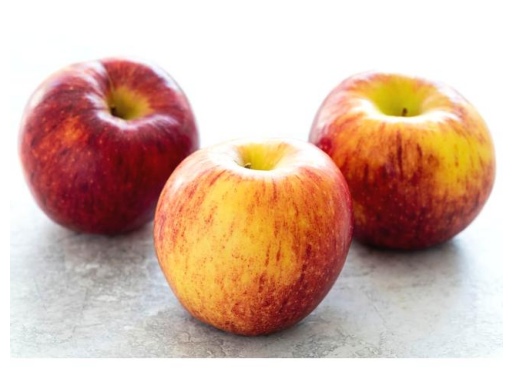

Image 0
Image shape: torch.Size([3, 480, 640])
Boxes: tensor([[189., 168., 445., 423.],
        [385.,  79., 633., 316.],
        [ 14.,  63., 249., 296.]])
Labels: tensor([1, 1, 1])


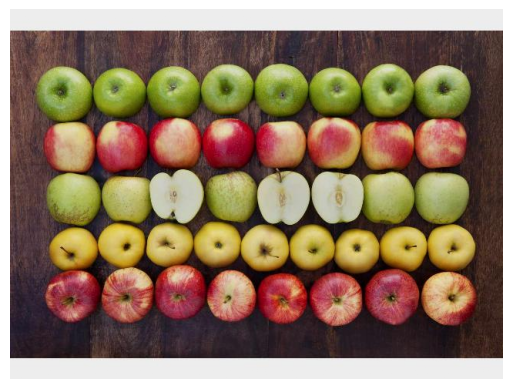

Image 1
Image shape: torch.Size([3, 480, 640])
Boxes: tensor([[ 34.,  74., 109., 147.],
        [109.,  76., 177., 142.],
        [179.,  74., 248., 141.],
        [250.,  72., 317., 139.],
        [318.,  70., 388., 139.],
        [387.,  76., 456., 141.],
        [458.,  70., 525., 139.],
        [525.,  73., 599., 142.],
        [526., 143., 595., 208.],
        [458., 143., 527., 209.],
        [386., 139., 456., 207.],
        [320., 145., 387., 206.],
        [250., 141., 317., 207.],
        [181., 140., 250., 208.],
        [111., 145., 181., 213.],
        [ 45., 146., 113., 212.],
        [ 46., 213., 118., 279.],
        [120., 218., 186., 278.],
        [181., 210., 251., 276.],
        [256., 210., 322., 277.],
        [324., 211., 391., 280.],
        [392., 212., 460., 278.],
        [456., 211., 526., 278.],
        [525., 212., 597., 279.],
        [534., 342., 607., 412.],
        [462., 338., 533., 411.],
        [388., 342., 458., 413.],
        [322., 343., 386., 4

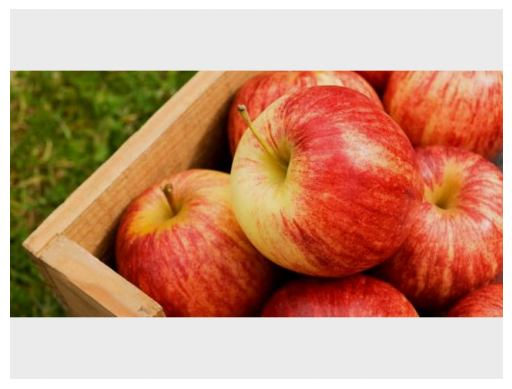

Image 2
Image shape: torch.Size([3, 480, 640])
Boxes: tensor([[284.,  99., 539., 347.],
        [136., 207., 347., 399.],
        [327., 346., 532., 400.],
        [453., 176., 640., 389.],
        [483.,  82., 640., 199.]])
Labels: tensor([1, 1, 1, 1, 1])


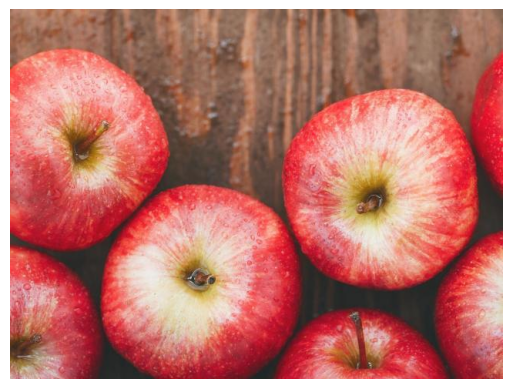

Image 3
Image shape: torch.Size([3, 480, 640])
Boxes: tensor([[356., 103., 609., 360.],
        [117., 228., 382., 478.],
        [351., 389., 572., 481.],
        [  2.,  50., 213., 313.],
        [  2., 306., 118., 481.]])
Labels: tensor([1, 1, 1, 1, 1])


In [16]:
# 데이터셋, 데이터로더 지정

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), list(targets)

dataset = CustomDataset('images', 'annotations', class_mapping, transforms=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Dataloader 테스트 용 코드
import matplotlib.pyplot as plt
import torch

def test_dataloader(dataloader):
    for imgs, targets in dataloader: 
        for i in range(len(imgs)):
            # 배치의 첫 번째 이미지만 선택
            img = imgs[i]

            # (3, 480, 640) 형태를 (480, 640, 3)으로 변환
            img = img.permute(1, 2, 0)

            # 텐서를 NumPy 배열로 변환
            img_np = img.numpy()

            # 이미지 표시
            plt.imshow(img_np)
            plt.axis('off')  # 축 제거
            plt.show()
            print("Image", i)
            print("Image shape:", imgs[i].shape)
            print("Boxes:", targets[i]['boxes'])
            print("Labels:", targets[i]['labels'])
        break  # 첫 번째 배치만 테스트

# 테스트 함수 실행
test_dataloader(dataloader)

---
모델 정의하기

In [12]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def get_model(num_classes):
    # 사전 학습된 모델 로드
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # 클래스 수에 맞게 분류 헤드 수정
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# 모델 인스턴스 생성
num_classes = 2 + 1  # 2개의 클래스 (red apple, green apple) + 배경
model = get_model(num_classes)

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

---
학습하기

In [13]:
# Optimizer 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler 설정
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 훈련 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
        print(f"Epoch: {epoch+1}, Step: {i+1}, Loss: {losses.item()}")
        i += 1
    
    lr_scheduler.step()

print("Training complete!")


Epoch: 1, Step: 1, Loss: 2.139974594116211
Epoch: 1, Step: 2, Loss: 1.3046379089355469
Epoch: 1, Step: 3, Loss: 1.1909148693084717
Epoch: 1, Step: 4, Loss: 1.1289432048797607
Epoch: 1, Step: 5, Loss: 1.3747361898422241
Epoch: 1, Step: 6, Loss: 1.2237842082977295
Epoch: 2, Step: 1, Loss: 0.8165103793144226
Epoch: 2, Step: 2, Loss: 0.7802615165710449
Epoch: 2, Step: 3, Loss: 0.7227156162261963
Epoch: 2, Step: 4, Loss: 0.8133102655410767
Epoch: 2, Step: 5, Loss: 0.5940070748329163
Epoch: 2, Step: 6, Loss: 0.4547966420650482
Epoch: 3, Step: 1, Loss: 0.5358245968818665
Epoch: 3, Step: 2, Loss: 0.4532032012939453
Epoch: 3, Step: 3, Loss: 0.5425702929496765
Epoch: 3, Step: 4, Loss: 0.5559256076812744
Epoch: 3, Step: 5, Loss: 0.5045322775840759
Epoch: 3, Step: 6, Loss: 0.4129753112792969
Epoch: 4, Step: 1, Loss: 0.38794445991516113
Epoch: 4, Step: 2, Loss: 0.48267191648483276
Epoch: 4, Step: 3, Loss: 0.39537277817726135
Epoch: 4, Step: 4, Loss: 0.5005610585212708
Epoch: 4, Step: 5, Loss: 0.382

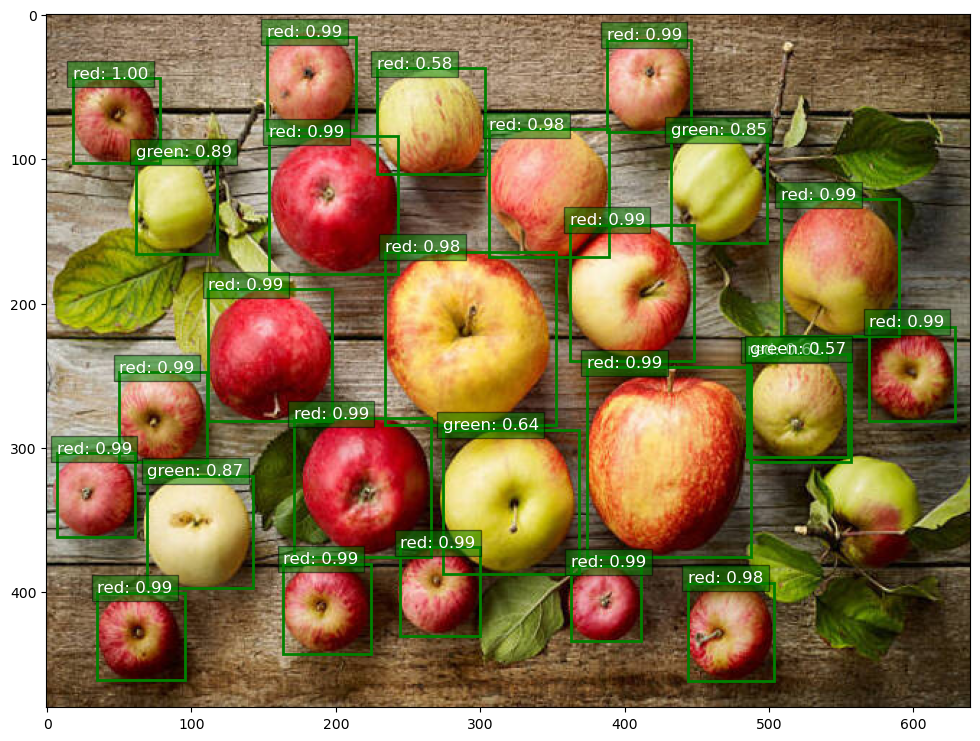

In [24]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 이미지 불러오기
image_path = 'apple.jpg'
image = Image.open(image_path).convert("RGB")

# 이미지 전처리
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # 배치 차원을 추가합니다.

# 모델 평가 모드로 전환
model.eval()

# 이미지가 GPU에 있을 경우 GPU로 이동
image_tensor = image_tensor.to(device)

# 예측 수행
with torch.no_grad():
    predictions = model(image_tensor)

# 예측 결과
pred_boxes = predictions[0]['boxes'].cpu().numpy()
pred_labels = predictions[0]['labels'].cpu().numpy()
pred_scores = predictions[0]['scores'].cpu().numpy()

# 시각화
fig, ax = plt.subplots(1, figsize=(12,9))

# 이미지 표시
ax.imshow(image)

def idx_to_class(label):
    return 'red' if label == 1 else 'green'

# 바운딩 박스 그리기
for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    if score > 0.5:  # confidence threshold 설정
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        edgecolor = 'r' if label == 0 else 'g'  # red apple은 빨간색, green apple은 초록색
        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none', linewidth=2)
        ax.add_patch(rect)
        label_name = idx_to_class(label)
        ax.text(xmin, ymin, f'{label_name}: {score:.2f}', bbox=dict(facecolor=edgecolor, alpha=0.5), fontsize=12, color='white')

plt.show()


In [1]:
# GPU 메모리 해제
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

---

<br>

---

<br>

---

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Dataloader 테스트 용 코드
import matplotlib.pyplot as plt
import torch


# 클래스 이름을 인덱스로 매핑하는 함수
def class_to_idx(label, class_mapping):
    return class_mapping[label]

# Example class mapping dictionary
class_mapping = {
    'red apple': 1,
    'green apple': 2,
}

# Dataset 지정
class CustomDataset(Dataset):
    def __init__(self, img_dir, anno_dir, class_mapping, transforms=None):
        self.img_dir = img_dir
        self.anno_dir = anno_dir
        self.class_mapping = class_mapping
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(img_dir)))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        anno_path = os.path.join(self.anno_dir, self.imgs[idx].replace('.jpg', '.xml'))
        
        img = Image.open(img_path).convert("RGB")
        
        # XML 파일에서 annotation 정보 추출
        tree = ET.parse(anno_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.iter('object'):
            name = obj.find('name').text
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            ymin = int(xmlbox.find('ymin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymax = int(xmlbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(name)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([class_to_idx(l, self.class_mapping) for l in labels], dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target

# 데이터셋, 데이터로더 지정

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), list(targets)

def test_dataloader(dataloader):
    for imgs, targets in dataloader: 
        for i in range(len(imgs)):
            # 배치의 첫 번째 이미지만 선택
            img = imgs[i]

            # (3, 480, 640) 형태를 (480, 640, 3)으로 변환
            img = img.permute(1, 2, 0)

            # 텐서를 NumPy 배열로 변환
            img_np = img.numpy()

            # 이미지 표시
            fig, ax = plt.subplots(1)
            ax.imshow(img_np)
            ax.axis('off')  # 축 제거

            # bbox 그리기
            for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
                xmin, ymin, xmax, ymax = box
                box_width = xmax - xmin
                box_height = ymax - ymin
                rect = patches.Rectangle((xmin, ymin), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label_name = label.item()

                ax.text(xmin, ymin, label_name, fontsize=8, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))

            plt.show()

            print("Image", i)
            print("Image shape:", imgs[i].shape)
            print("Number of boxes:", len(targets[i]['boxes']))
            print("Boxes:", targets[i]['boxes'])
            print("Labels:", targets[i]['labels'])
        break  # 첫 번째 배치만 테스트

dataset = CustomDataset('images', 'annotations', class_mapping, transforms=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)


# 테스트 함수 실행
# test_dataloader(dataloader)


In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 1. 모델 정의
def get_model(num_classes):
    # 미리 학습된 모델을 불러옵니다
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 분류기를 새로운 것으로 교체합니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 클래스 수 정의 (배경 클래스 포함)
num_classes = 3  # 배경 + red apple + green apple

# 모델 생성
model = get_model(num_classes)

c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---
(다른 백본 버전) MobileNetV3 백본


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_mobilenetv3(num_classes):
    # MobileNetV3-Large를 백본으로 로드
    backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
    
    # Faster R-CNN에 필요한 출력 채널 수
    backbone.out_channels = 960
    
    # Anchor 생성기 정의
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # ROI pooler 정의
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    
    # Faster R-CNN 모델 생성
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    
    return model

# 클래스 수 정의 (배경 클래스 포함)
num_classes = 3  # 배경 + red apple + green apple

# 모델 생성
model = get_model_mobilenetv3(num_classes)

---
VGG16 

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        
        self.features = nn.Sequential(
             # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
                   
        )
        
        # 출력 채널 수 정의
        self.out_channels = 512

    def forward(self, x):
        x = self.features(x)
        return x

class CustomFasterRCNN(FasterRCNN):
    def __init__(self, backbone, num_classes=3, **kwargs):
        super(CustomFasterRCNN, self).__init__(backbone, num_classes, **kwargs)

        # ROI pooling 출력 크기
        output_size = 7  # MultiScaleRoIAlign의 output_size
        in_channels = backbone.out_channels

        # 커스텀 box head 정의 (컨볼루션 레이어 사용)
        self.roi_heads.box_head = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # 커스텀 box predictor 정의
        self.roi_heads.box_predictor = FastRCNNPredictor(256, num_classes)

    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        
        if isinstance(features, torch.Tensor):
            features = {'0': features}
        
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if self.training:
            return losses

        return detections

def get_custom_faster_rcnn(num_classes):
    # 커스텀 백본 생성
    backbone = CustomBackbone()
    
    # Anchor 생성기 정의
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # ROI pooler 정의
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                    output_size=7,
                                    sampling_ratio=2)
    
    # 커스텀 Faster R-CNN 모델 생성
    model = CustomFasterRCNN(backbone,
                             num_classes=num_classes,
                             rpn_anchor_generator=anchor_generator,
                             box_roi_pool=roi_pooler)
    
    return model

# 클래스 수 정의 (배경 클래스 포함)
num_classes = 3  # 배경 + red apple + green apple

# 모델 생성
model = get_custom_faster_rcnn(num_classes)

---
다른 버전 : 진짜 커스텀

In [27]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        
        self.features = nn.Sequential(
            # 첫 번째 레이어: 입력 채널 3 (RGB)
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),     
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),             
                               
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),     
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
        )
        
        # 출력 채널 수 정의
        self.out_channels = 128

    def forward(self, x):
        x = self.features(x)
        return x

class CustomFasterRCNN(FasterRCNN):
    def __init__(self, backbone, num_classes=3, **kwargs):
        super(CustomFasterRCNN, self).__init__(backbone, num_classes, **kwargs)

        # ROI pooling 출력 크기
        output_size = 7  # MultiScaleRoIAlign의 output_size
        in_channels = backbone.out_channels

        # 커스텀 box head 정의 (컨볼루션 레이어 사용)
        self.roi_heads.box_head = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # 커스텀 box predictor 정의
        self.roi_heads.box_predictor = FastRCNNPredictor(256, num_classes)

    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        
        if isinstance(features, torch.Tensor):
            features = {'0': features}
        
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if self.training:
            return losses

        return detections

def get_custom_faster_rcnn(num_classes):
    # 커스텀 백본 생성
    backbone = CustomBackbone()
    
    # Anchor 생성기 정의
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # ROI pooler 정의
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                    output_size=7,
                                    sampling_ratio=2)
    
    # 커스텀 Faster R-CNN 모델 생성
    model = CustomFasterRCNN(backbone,
                             num_classes=num_classes,
                             rpn_anchor_generator=anchor_generator,
                             box_roi_pool=roi_pooler)
    
    return model

# 클래스 수 정의 (배경 클래스 포함)
num_classes = 3  # 배경 + red apple + green apple

# 모델 생성
model = get_custom_faster_rcnn(num_classes)

---

In [3]:
# 2. 학습 함수 정의
def train_model(model, dataloader, num_epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    for epoch in range(num_epochs):
        model.train()
        i = 0
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            i += 1
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {losses.item():.4f}")

# 3. 모델 학습, 3070 기준 3m 30s 소요, imgs == 24
train_model(model, dataloader, num_epochs=100)

Epoch [1/100], Step [1/6], Loss: 2.6123
Epoch [1/100], Step [2/6], Loss: 2.9183
Epoch [1/100], Step [3/6], Loss: 3.0458
Epoch [1/100], Step [4/6], Loss: 2.6970
Epoch [1/100], Step [5/6], Loss: 2.9906
Epoch [1/100], Step [6/6], Loss: 2.7413
Epoch [2/100], Step [1/6], Loss: 2.7840
Epoch [2/100], Step [2/6], Loss: 2.6472
Epoch [2/100], Step [3/6], Loss: 2.8077
Epoch [2/100], Step [4/6], Loss: 2.7836
Epoch [2/100], Step [5/6], Loss: 2.6992
Epoch [2/100], Step [6/6], Loss: 2.9711
Epoch [3/100], Step [1/6], Loss: 2.9603
Epoch [3/100], Step [2/6], Loss: 2.6235
Epoch [3/100], Step [3/6], Loss: 2.9465
Epoch [3/100], Step [4/6], Loss: 2.3658
Epoch [3/100], Step [5/6], Loss: 2.7242
Epoch [3/100], Step [6/6], Loss: 2.2366
Epoch [4/100], Step [1/6], Loss: 2.8078
Epoch [4/100], Step [2/6], Loss: 2.6473
Epoch [4/100], Step [3/6], Loss: 2.5611
Epoch [4/100], Step [4/6], Loss: 2.0475
Epoch [4/100], Step [5/6], Loss: 2.7763
Epoch [4/100], Step [6/6], Loss: 2.0848
Epoch [5/100], Step [1/6], Loss: 2.2347


KeyboardInterrupt: 

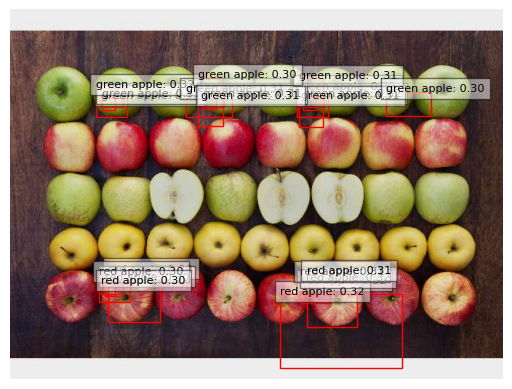

In [26]:
# 4. 모델 저장
torch.save(model.state_dict(), 'apple_detector.pth')

# 5. 이미지 예측 함수 수정
def predict_image(model, image_path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()
    
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)
    
    # 예측 결과를 CPU로 이동
    prediction = {k: v.cpu() for k, v in prediction[0].items()}
    
    return img, prediction

# 7. 결과 시각화 함수 수정
def visualize_prediction(img, prediction, threshold=0.3):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > threshold:
            xmin, ymin, xmax, ymax = box.numpy()
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            label_name = [k for k, v in class_mapping.items() if v == label.item()][0]
            ax.text(xmin, ymin, f"{label_name}: {score:.2f}", 
                    fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# 6. 저장된 모델 불러오기 및 예측
model.load_state_dict(torch.load('apple_detector.pth'))
img, prediction = predict_image(model, 'apple2.jpg')

# 예측 결과 시각화
visualize_prediction(img, prediction)

In [14]:
import torch
import json
import os

# .pth 파일 로드
data = torch.load('apple_detector.pth')

# 저장할 디렉토리 생성
save_dir = './weights'
os.makedirs(save_dir, exist_ok=True)

# 내용을 파일로 추출하는 함수 정의
def save_tensor_to_json(tensor, filename):
    # CUDA 장치에서의 텐서인 경우 CPU로 복사
    tensor = tensor.cpu() if tensor.is_cuda else tensor
    # Tensor를 Numpy 배열로 변환
    array = tensor.numpy() if isinstance(tensor, torch.Tensor) else tensor
    # JSON 파일로 저장
    with open(filename, 'w') as f:
        json.dump(array.tolist(), f)

# 각 항목을 파일로 추출
for key, value in data.items():
    # 파일명 설정
    filename = os.path.join(save_dir, f"{key}.json")
    # 값이 텐서인 경우 파일로 저장
    if isinstance(value, torch.Tensor):
        save_tensor_to_json(value, filename)
    else:
        # 텐서가 아닌 경우 예외 처리
        print(f"Skipping {key} because it is not a tensor.")

    print(f"Saved {key} to {filename}")


Saved backbone.features.0.weight to ./weights\backbone.features.0.weight.json
Saved backbone.features.0.bias to ./weights\backbone.features.0.bias.json
Saved backbone.features.1.weight to ./weights\backbone.features.1.weight.json
Saved backbone.features.1.bias to ./weights\backbone.features.1.bias.json
Saved backbone.features.1.running_mean to ./weights\backbone.features.1.running_mean.json
Saved backbone.features.1.running_var to ./weights\backbone.features.1.running_var.json
Saved backbone.features.1.num_batches_tracked to ./weights\backbone.features.1.num_batches_tracked.json
Saved backbone.features.3.weight to ./weights\backbone.features.3.weight.json
Saved backbone.features.3.bias to ./weights\backbone.features.3.bias.json
Saved backbone.features.4.weight to ./weights\backbone.features.4.weight.json
Saved backbone.features.4.bias to ./weights\backbone.features.4.bias.json
Saved backbone.features.4.running_mean to ./weights\backbone.features.4.running_mean.json
Saved backbone.featu